##0. Import Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

# 1. Train bot

In [0]:
%tensorflow_version 1.x

In [119]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import json
import pickle
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
import random

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
#@title a : Train { run: "auto" }
words=[]
classes = []
documents = []
ignore_words = ['?', '!']
data_file = open('/content/drive/My Drive/relinns_mohit/chatbot/intents.json').read()
intents = json.loads(data_file)

for intent in intents['intents']:
    for pattern in intent['patterns']:
        #tokenize each word
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        #add documents in the corpus
        documents.append((w, intent['tag']))
        # add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

# lemmaztize and lower each word and remove duplicates
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))
# sort classes
classes = sorted(list(set(classes)))
# documents = combination between patterns and intents
print (len(documents), "documents")
# classes = intents
print (len(classes), "classes", classes)
# words = all words, vocabulary
print (len(words), "unique lemmatized words", words)

pickle.dump(words,open('words.pkl','wb'))
pickle.dump(classes,open('classes.pkl','wb'))

# create our training data
training = []
# create an empty array for our output
output_empty = [0] * len(classes)
# training set, bag of words for each sentence
for doc in documents:
    # initialize our bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
    # lemmatize each word - create base word, in attempt to represent related words
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    # create our bag of words array with 1, if word match found in current pattern
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)
    
    # output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    
    training.append([bag, output_row])
# shuffle our features and turn into np.array
random.shuffle(training)
training = np.array(training)
# create train and test lists. X - patterns, Y - intents
train_x = list(training[:,0])
train_y = list(training[:,1])
print("Training data created")

# Create model - 3 layers. First layer 128 neurons, second layer 64 neurons and 3rd output layer contains number of neurons
# equal to number of intents to predict output intent with softmax
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

#fitting and saving the model 
hist = model.fit(np.array(train_x), np.array(train_y), epochs=200, batch_size=5, verbose=1)
model.save('chatbot_model.h5', hist)

print("model created")

In [0]:
# @title b : Deleted drive trained files
!rm "/content/drive/My Drive/relinns_mohit/chatbot/chatbot_model.h5"
!rm "/content/drive/My Drive/relinns_mohit/chatbot/classes.pkl"
!rm "/content/drive/My Drive/relinns_mohit/chatbot/words.pkl"

In [0]:
# @title c : Copy trained models and picklke files to drive
!gsutil -q -m cp /content/chatbot_model.h5 /content/drive/My\ Drive/relinns_mohit/chatbot
!gsutil -q -m cp /content/classes.pkl /content/drive/My\ Drive/relinns_mohit/chatbot
!gsutil -q -m cp /content/words.pkl /content/drive/My\ Drive/relinns_mohit/chatbot

#2. Chatbot (output function)
## combining api

In [125]:
%tensorflow_version 1.x
from keras.models import load_model
import json
import pickle
import numpy as np
import random
import sys
sys.path.insert(0, "/content/drive/My Drive/relinns_mohit/chatbot")
model = load_model(sys.path[0]+'/chatbot_model.h5',compile = False)
intents = json.loads(open(sys.path[0]+'/intents.json').read())
words = pickle.load(open(sys.path[0]+'/words.pkl','rb'))
classes = pickle.load(open(sys.path[0]+'/classes.pkl','rb'))
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


##2.1 Trained Model output
*intent manual data trained model*

In [129]:
# title Chatbot_response { run: "auto" }
def clean_up_sentence(sentence):
    # tokenize the pattern - split words into array
    sentence_words = nltk.word_tokenize(sentence)
    # stem each word - create short form for word
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
    # print("sentence words : ",sentence_words)
    return sentence_words
# return bag of words array: 0 or 1 for each word in the bag that exists in the sentence
def bow(sentence, words, show_details=True):
    # tokenize the pattern
    sentence_words = clean_up_sentence(sentence)
    # bag of words - matrix of N words, vocabulary matrix
    bag = [0]*len(words)  
    for s in sentence_words:
        for i,w in enumerate(words):
            if w == s: 
                # assign 1 if current word is in the vocabulary position
                bag[i] = 1
                if show_details:
                    print ("found in bag: %s" % w)
    # print(np.array(bag))
    return(np.array(bag))
def predict_class(sentence, model):
    # filter out predictions below a threshold
    p = bow(sentence, words,show_details=False)
    res = model.predict(np.array([p]))[0]
    ERROR_THRESHOLD = 0.25
    results = [[i,r] for i,r in enumerate(res) if r>ERROR_THRESHOLD]
    # sort by strength of probability
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
    # print('return_list',return_list)
    return return_list
def getResponse(ints, intents_json):  #not important just giving random response from predicted class
    tag = ints[0]['intent']
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if(i['tag']== tag):
            result = random.choice(i['responses'])
            break
    return result
def chatbot_response(msg):   
    ints = predict_class(msg, model) 
    res = getResponse(ints, intents)
    return res,ints[0]['intent'],ints[0]['probability']      #return response and class which querry belongs

chatbot_response("g")

IndexError: ignored

##2.2 web result based api output
*WHen manual trained model failed to anser this funcion run to get online answer for client querry*

In [128]:
import requests
import string
from lxml import html
from googlesearch import search
from bs4 import BeautifulSoup
block_url=["youtube"]
# import time
def chatbot_query(query, index=0):  #google search
    fallback = 'Sorry, I cannot think of a reply for that.'
    result = ''
    try:
        search_result_list = list(search(query, tld="co.in", num=10, stop=3, pause=1))
        print(search_result_list)
        page = requests.get(search_result_list[index])
        tree = html.fromstring(page.content)
        soup = BeautifulSoup(page.content, features="lxml")
        article_text = ''
        article = soup.findAll('p')  #all paragraph
        # print("article->",article)
        for element in article:
            print(element)
            article_text += '\n' + ''.join(element.findAll(text = True))
        article_text = article_text.replace('\n', '')
        first_sentence = article_text.split('.')
        first_sentence = first_sentence[0].split('?')[0]
        chars_without_whitespace = first_sentence.translate(
            { ord(c): None for c in string.whitespace }
        )
        if len(chars_without_whitespace) > 0:
            result = first_sentence
        else:
            result = fallback
        return result
    except:
        if len(result) == 0: result = fallback
        return result       
chatbot_query("#")

['https://commons.wikimedia.org/wiki/File:Number_sign.svg?sa=X&ved=2ahUKEwizt73u1svoAhVjFTQIHZkvA9cQ9QF6BAgGEAI', 'https://en.wikipedia.org/wiki/Number_sign', 'https://en.wikipedia.org/wiki/Hashtag']
<p><a class="internal" href="https://upload.wikimedia.org/wikipedia/commons/6/63/Number_sign.svg" title="Number sign.svg">Original file</a> ‎<span class="fileInfo">(SVG file, nominally 153 × 159 pixels, file size: 768 bytes)</span>
</p>
<p><b>Number sign <big>#</big></b> (Unicode glyph U+0023), in Arial Font <br/>
<i>Not</i> equal to the music <b>sharp sign <a href="/wiki/File:Sharp.svg" title="File:Sharp.svg"><big>♯</big></a></b> (Unicode glyph U+266F)
</p>
<p><img alt="Dialog-warning.svg" data-file-height="48" data-file-width="48" decoding="async" height="22" src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/6e/Dialog-warning.svg/22px-Dialog-warning.svg.png" srcset="https://upload.wikimedia.org/wikipedia/commons/thumb/6/6e/Dialog-warning.svg/33px-Dialog-warning.svg.png 1.5x, ht

'Original file \u200e(SVG file, nominally 153 × 159 pixels, file size: 768 bytes)Number sign # (Unicode glyph U+0023), in Arial Font Not equal to the music sharp sign ♯ (Unicode glyph U+266F) Please check the source to verify that this is correct'

## 2.3 wikipedia api  (only good for specific word)

In [0]:
!pip install wikipedia  

In [0]:
#wikipedia 
import wikipedia
def wiki_suggest(query):
  return(wikipedia.suggest(query))

def wiki_search(query):
  return(wikipedia.search(query, results=3))

def wiki_summary(query):
  return(wikipedia.summary(query, sentences=2))

In [0]:
query="whats the weather"

In [105]:
chatbot_query(query)

['https://www.youtube.com/watch?v=KUSbazn3STo', 'https://www.youtube.com/watch?v=Jn7uAsLWXpk', 'https://www.youtube.com/watch?v=rD6FRDd9Hew&vl=en']


'Sorry, I cannot think of a reply for that.'

In [0]:
wiki_suggest(query)

In [107]:
wiki_search(query)

['Weather', 'Weather forecasting', 'The Weather Channel']

In [108]:
 # produce error if wuery is not good
 wiki_summary(query)    # (wiki_search) -> then (wiki_summary) will work


'Weather is the state of the atmosphere, describing for example the degree to which it is hot or cold, wet or dry, calm or stormy, clear or cloudy.  Most weather phenomena occur in the lowest level of the atmosphere, the troposphere, just below the stratosphere.'

##2.4 jokes api


In [86]:
! pip install pyjokes     #technical joke
# !pip install axju-jokes  #integrate later
import pyjokes 
def jokes():
  return(pyjokes.get_joke())

#3. Output

In [0]:
#@title Combined api Output
import time
wiki_searched=[]
yes=('yes','y','yeah','sure','ys','ya','yup','yo')
while True:
  s = str(input("You :  "))
  if s.lower() in ("bye","bi","exit","goodbye"):
    print("Thanks for chatting with me")
    break
  else:
    response,clas,accuracy = chatbot_response(s)
    # if response == "Sorry, can't understand you" :
    if clas in ('abuse','noanswer'):      

        if wiki_suggest(s) is not None:
          print("Bot :  Are you looking for :",wiki_suggest(s)),"?"
          
          if input("You :  ").lower() in yes:
            print("Bot : ",wiki_summary(str(wiki_suggest(s))))
          else:
            print("Bot : Hold On ! Maybe this :",chatbot_query(s)) 
        
        else :
          print("Bot : ",chatbot_query(s)) 
    
    elif clas in ('options'):
      print("Bot : ",response)
      print("Bot : ","Want to know more about Me") 
      if input("You : ").lower() in yes:
        print("chatbot ")

    else:
      print("Bot : ",response)
    while clas in ('jokes'): 
      print(jokes(),"\n")
      print("Bot : Do you want more ?" )
      if input("You :  ").lower() in yes:
        continue
      else:
        break

#* Extra things that will the part of above tabs

### auto suggestion and completion

In [38]:
import requests, json
URL="http://suggestqueries.google.com/complete/search?client=firefox&q=Hel Wor"
headers = {'User-agent':'Mozilla/5.0'}
response = requests.get(URL, headers=headers)
result = json.loads(response.content.decode('utf-8'))
print(result)

['Hel Wor', ['hel words', 'hel worship', 'hel words start', 'help word', 'help works', 'help worldwide', 'help words with friends', 'help wordpress', 'help word origin', 'help world hunger']]


### wordcloud

In [40]:
import json
nltk.download('stopwords')
intents = json.loads(open('/content/drive/My Drive/relinns_mohit/chatbot/intents.json').read())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
listt=[]
for i in intents["intents"]:
  for j in i["responses"]:
    listt.append(j)

In [73]:
listt

['Well i am a chatbot , A chatbot is a conversational user interface that will stimulate conversation with users provide customer support, and solves customer queries within no time.Are there any contracts for using this platform',
 'We do offer a free chatbot in our Baby plan which comes with 60 FREE interactions per month, there is no need to pay or provide credit/debit card details, you can simply avail it by signing up',
 'BotPenguin understands that your privacy is paramount, it values and protects your data. BotPenguin is GDPR complaint to meet international standards of data privacy. It follows strict guidelines and policies to safeguard collected data through lead generation and customer support',
 'BotPenguin understands that your privacy is paramount, it values and protects your data. BotPenguin is GDPR complaint to meet international standards of data privacy. It follows strict guidelines and policies to safeguard collected data through lead generation and customer support. 

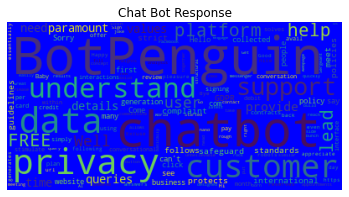

In [76]:
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
stop = set(stopwords.words('english'))

import matplotlib.pyplot as plt

def cloud(text):
    # import pdb;pdb.set_trace()
    wordcloud = WordCloud(background_color="blue",stopwords=stop).generate(" ".join([i for i in text]))
    print(wordcloud)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Chat Bot Response")

cloud(listt)

In [77]:
!nvidia-smi

Thu Apr  2 08:45:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    34W / 250W |    389MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [110]:
requests('http://suggestqueries.google.com/complete/search?client=chrome&q=what is sexx&callback=callback')

ERROR! Session/line number was not unique in database. History logging moved to new session 61


TypeError: ignored